This notebook runs a defined pipeline on HCP subjects, on the Cedars-Sinai cluster.
After it is done preprocessing all subjects, it runs the leave-one-family-out personality prediction.

# Load libraries & helper functions

In [1]:
from helpers import *
%matplotlib inline

# Declare parameters

In [2]:
config.DATADIR                 = '/scratch/duboisjx/data/HCP/MRI'
config.release                 = 'all+MEG2'
config.pipelineName            = 'Ciric6'
# fMRI runs
fmriRuns                       = ['rfMRI_REST1_LR','rfMRI_REST1_RL','rfMRI_REST2_LR','rfMRI_REST2_RL']
# use volume or surface data
config.fmriFileTemplate        = '#fMRIrun#_Atlas_MSMAll.dtseries.nii'
config.melodicFolder           = op.join('#fMRIrun#_hp2000.ica','filtered_func_data.ica') #the code #fMRIrun# will be replaced
config.movementRelativeRMSFile = 'Movement_RelativeRMS.txt'
config.movementRegressorsFile  = 'Movement_Regressors_dt.txt'
# parcellation for FC matrix
config.parcellationName        = 'Glasser'
config.parcellationFile        = '/scratch/duboisjx/data/parcellations/Glasser2016/Parcels.dlabel.nii'
config.nParcels                = 360
config.maskParcelswithAll      = True
config.maskParcelswithGM       = False
# subject selection parameters
config.behavFile               = '/scratch/duboisjx/data/HCP/neuropsych/unrestricted_luckydjuju_6_7_2017_0_44_41.csv'
config.RbehavFile              = '/scratch/duboisjx/data/HCP/neuropsych/RESTRICTED_luckydjuju_8_22_2017_11_13_18.csv'
# submit jobs with sge
config.queue        = True
# do not alter the following lines
if config.maskParcelswithGM:
    config.parcellationName = config.parcellationName + '_GM'
tmp = config.fmriFileTemplate.split('.')
if tmp[1]=='nii':
    config.isCifti = False
elif tmp[1]=='dtseries':
    config.isCifti = True
else:
    print 'unknown file extension'
config.preWhitening            = False
# whether to use memmapping (which involves unzipping)
# deprecated
config.useMemMap               = False

# output directory
outDir              = op.join(config.DATADIR,'Results','FINAL',config.pipelineName,config.parcellationName)
if not op.isdir(outDir):
    makedirs(outDir)

# Subject selection

diffO=0, diffC=0, diffE=0, diffA=2682, diffN=0
Selected 1206 subjects for release all+MEG2
Kept 998 subjects with complete datasets
Kept 997 subjects after MMSE<26 exclusion criterion
Keeping 880 subjects after excluding high motion
Keeping 867 subjects [402 M] after excluding outliers
Age range is 22 - 36


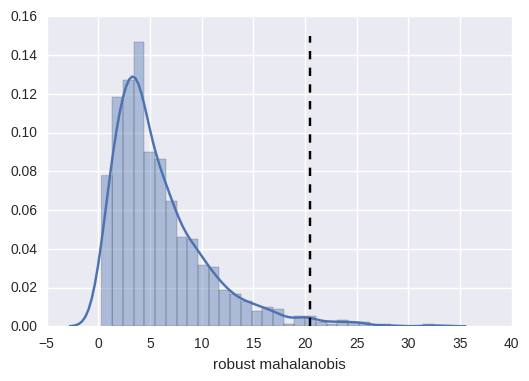

In [3]:
Udf = pd.read_csv(config.behavFile)
Rdf = pd.read_csv(config.RbehavFile)
# merge unrestricted and restricted
df = pd.merge(Udf,Rdf,how='inner')

# keep only variables of interest
df = df[['Subject','Release','Gender','Family_ID','Father_ID','Mother_ID','Age_in_Yrs','FS_BrainSeg_Vol','fMRI_3T_ReconVrs',
        '3T_RS-fMRI_PctCompl','PMAT_Compl','NEO-FFI_Compl','MMSE_Compl',
        'PMAT24_A_CR','MMSE_Score','NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A','NEOFAC_N',
        'NEORAW_01','NEORAW_02','NEORAW_03','NEORAW_04','NEORAW_05','NEORAW_06','NEORAW_07','NEORAW_08','NEORAW_09','NEORAW_10',
        'NEORAW_11','NEORAW_12','NEORAW_13','NEORAW_14','NEORAW_15','NEORAW_16','NEORAW_17','NEORAW_18','NEORAW_19','NEORAW_20',
        'NEORAW_21','NEORAW_22','NEORAW_23','NEORAW_24','NEORAW_25','NEORAW_26','NEORAW_27','NEORAW_28','NEORAW_29','NEORAW_30',
        'NEORAW_31','NEORAW_32','NEORAW_33','NEORAW_34','NEORAW_35','NEORAW_36','NEORAW_37','NEORAW_38','NEORAW_39','NEORAW_40',
        'NEORAW_41','NEORAW_42','NEORAW_43','NEORAW_44','NEORAW_45','NEORAW_46','NEORAW_47','NEORAW_48','NEORAW_49','NEORAW_50',
        'NEORAW_51','NEORAW_52','NEORAW_53','NEORAW_54','NEORAW_55','NEORAW_56','NEORAW_57','NEORAW_58','NEORAW_59','NEORAW_60',
        'PicSeq_Unadj','CardSort_Unadj','Flanker_Unadj','ReadEng_Unadj',
        'ProcSpeed_Unadj','DDisc_AUC_200','DDisc_AUC_40K','VSPLOT_TC','SCPT_SEN','SCPT_SPEC',
        'IWRD_TOT','ListSort_Unadj','PicVocab_Unadj','ER40_CR','AngAffect_Unadj',
        'AngHostil_Unadj','AngAggr_Unadj','FearAffect_Unadj','FearSomat_Unadj','Sadness_Unadj',
        'LifeSatisf_Unadj','MeanPurp_Unadj','PosAffect_Unadj','Friendship_Unadj','Loneliness_Unadj',
        'PercHostil_Unadj','PercReject_Unadj','EmotSupp_Unadj','InstruSupp_Unadj',
        'PercStress_Unadj','SelfEff_Unadj']]

scoring = [ 
    {'13':'n', '23':'r', '43':'n', #aesthetic interests
    '48':'r', '53':'n', '58':'n', #intellectual interests
    '03':'r', '08':'r', '18':'r', '38':'r', # unconventionality
    '28':'n', '33':'r'},#??
    {'05':'n', '10':'n', '15':'r', '30':'r', '55':'r', # orderliness
    '25':'n', '35':'n', '60':'n', # goal-striving
    '20':'n', '40':'n', '45':'r', '50':'n'}, # dependability
    {'07':'n', '12':'r', '37':'n', '42':'r', # positive affect
   '02':'n', '17':'n', '27':'r', '57':'r', # sociability
   '22':'n', '32':'n', '47':'n', '52':'n'}, # activity
    {'09':'r', '14':'r', '19':'n', '24':'r', '29':'r', '44':'r', '54':'r', '59':'r', #nonantagonistic orientation
   '04':'n', '34':'n', '39':'r', '49':'n'}, # prosocial orientation
    {'01':'r', '11':'n', '16':'r', '31':'r', '46':'r', # negative affect
   '06':'n', '21':'n', '26':'n', '36':'n', '41':'n', '51':'n', '56':'n'} # self-reproach
    ]
# RECOMPUTE FACTOR SCORES
factors = ['O','C','E','A','N']
scoreL  = ['NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A_corr', 'NEOFAC_N']

diff     = list()
for iFac,factor in enumerate(factors):
    this       = np.zeros(df.shape[0])
    keyCtr = -1
    for key in scoring[iFac].keys():
        if scoring[iFac][key]=='n':
            df['NEORAW_'+key].replace(['SD','D','N','A','SA'],[0,1,2,3,4],inplace=True)
        else:
            df['NEORAW_'+key].replace(['SD','D','N','A','SA'],[4,3,2,1,0],inplace=True)
        this = this + df['NEORAW_'+key]
        keyCtr += 1
    df['NEOFAC_'+factor+'_calc']=this
    diff.append(np.sum(np.abs(df['NEOFAC_'+factor]-df['NEOFAC_'+factor+'_calc'])))
print 'diffO={0:d}, diffC={1:d}, diffE={2:d}, diffA={3:d}, diffN={4:d}'.format(
    np.int(diff[0]),np.int(diff[1]),np.int(diff[2]),np.int(diff[3]),np.int(diff[4]))
# correct scores
df['NEOFAC_A_corr']  = df['NEOFAC_A_calc']

# select subjects according to release
if config.release == 'Q2':
    keepSub = (df['Release'] == 'Q2') | (df['Release'] == 'Q1')
elif config.release == 'S500':
    keepSub = (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'Q2+S500':
    keepSub = (df['Release'] == 'Q2') | (df['Release'] == 'Q1') | (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'S900':
    keepSub = (df['Release'] == 'S900')
elif config.release == 'S1200':
    keepSub = (df['Release'] == 'S1200')
elif config.release == 'all':
    keepSub = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200'))
elif config.release == 'all+MEG2':
    keepSub = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200') 
           | (df['Release'] == 'MEG2'))
else:
    sys.exit("Invalid release code")
print 'Selected {} subjects for release {}'.format(np.sum(keepSub),config.release)

# select subjects that have completed all fMRI
keepSub = keepSub & (
    (df['3T_RS-fMRI_PctCompl']==100) & 
    (df['PMAT_Compl']==True) &
    (df['NEO-FFI_Compl']==True)&
    (df['MMSE_Compl']==True))
# remove subject missing item scores for NEO
keepSub = keepSub & (
    ~df['Subject'].isin([131924]))
print 'Kept {} subjects with complete datasets'.format(np.sum(keepSub))

# # check if either of the two subjects recommended for exclusion by HCP are still present
# keepSub = keepSub & (
#     ~df['Subject'].isin([209733,528446]))

# FURTHER EXCLUSIONARY CRITERIA
# --> MMSE <26 excluded
keepSub    = np.logical_and(keepSub,df['MMSE_Score']>=26)
print 'Kept {} subjects after MMSE<26 exclusion criterion'.format(np.sum(keepSub))

# PRUNE df 
df        = df[keepSub]
# reindex
df.index  = range(df.shape[0])

# Exclusion of high-motion subjects
# exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)
RelRMSMean = np.zeros([len(df['Subject']), len(fmriRuns)],dtype=np.float32)
FDsum      = np.zeros([len(df['Subject']), len(fmriRuns)],dtype=np.float32)
keepSub    = np.zeros((len(df['Subject'])),dtype=np.bool_)
iSub=0
excluded = list()
for subject in df['Subject']:
    config.subject=str(subject)
    # RelRMSMean
    i=0
    for config.fmriRun in fmriRuns:
        RelRMSMeanFile = op.join(buildpath(), 'Movement_RelativeRMS_mean.txt')
        if op.isfile(RelRMSMeanFile):
            with open(RelRMSMeanFile,'r') as tmp:
                RelRMSMean[iSub,i] = float(tmp.read())
        else:
            excluded.append(config.subject)
            #print RelRMSMeanFile+' File missing'
            break
        i=i+1
    if i==len(fmriRuns): # all RelRMSMeanFile exist
        if np.any(RelRMSMean[iSub,:] > 0.15):
            excluded.append(config.subject)
        else:
            keepSub[iSub]=True
    # total framewise displacement
    i=0
    for config.fmriRun in fmriRuns:
        FDsumFile = op.join(buildpath(), 'FD_sum.txt')
        if not op.isfile(FDsumFile):
            motionFile = op.join(buildpath(), config.movementRegressorsFile)
            if op.isfile(motionFile):
                dmotpars = np.abs(np.genfromtxt(motionFile)[:,6:]) #derivatives
                headradius=50 #50mm as in Powers et al. 2012
                disp=dmotpars.copy()
                disp[:,3:]=np.pi*headradius*2*(disp[:,3:]/360)
                thisFDsum=np.sum(np.sum(disp,1),0)
                with open(FDsumFile,'w') as tmp:
                    tmp.write(str(thisFDsum))
            else:
                break
        with open(FDsumFile,'r') as tmp:
            FDsum[iSub,i] = float(tmp.read())
        i=i+1
    iSub=iSub+1

# add RelRMSMean and FDsum to the dataframe
df['RelRMSMean_REST1'] = np.mean(RelRMSMean[:,0:2],axis=1)
df['FDsum_REST1']      = np.mean(FDsum[:,0:2],axis=1)
df['RelRMSMean_REST2'] = np.mean(RelRMSMean[:,2:4],axis=1)
df['FDsum_REST2']      = np.mean(FDsum[:,2:4],axis=1)

# PRUNE df 
df        = df[keepSub]
# reindex
df.index  = range(df.shape[0])
print 'Keeping {} subjects after excluding high motion'.format(len(df['Subject']))

#--------------------
# OUTLIER DETECTION
#--------------------
scoreMat = None
for score in scoreL:
    # add to conMat
    if scoreMat is None:
        scoreMat = np.ravel(df[score])
    else:
        scoreMat = np.vstack((scoreMat,np.ravel(df[score])))
# fit a Minimum Covariance Determinant (MCD) robust estimator to data
rbX            = RobustScaler()
scoreMatScaled = rbX.fit_transform(scoreMat.T)
robust_cov   = MinCovDet(assume_centered=True,support_fraction=.75).fit(scoreMatScaled)
robust_mahal = robust_cov.mahalanobis(scoreMatScaled - robust_cov.location_)
outlierThr = stats.chi2.isf(q=0.001,df=scoreMatScaled.shape[1])
sns.distplot(robust_mahal)
plt.plot([outlierThr, outlierThr],[0., .15],"k--")
plt.xlabel('robust mahalanobis')
isOut = (robust_mahal>=outlierThr)
# print df[isOut]

# PRUNE df 
df        = df[np.logical_not(isOut)]
df.index  = range(df.shape[0])
print 'Keeping {} subjects [{} M] after excluding outliers'.format(len(df['Subject']),sum([g=='M' for g in df['Gender']]))

print 'Age range is', np.min(df['Age_in_Yrs']), '-', np.max(df['Age_in_Yrs'])

# replace labeled columns with dummies
df['Gender'].replace(['F','M'],[1,2],inplace=True)
df['fMRI_3T_ReconVrs'].replace(['r177','r177 r227','r227'],[1,2,3],inplace=True)

In [4]:
# Compute Cronbach's Alpha
def CronbachAlpha(itemScores):
    itemVars   = itemScores.var(axis=1, ddof=1)
    totScores  = itemScores.sum(axis=0)
    nItems     = itemScores.shape[0]
    return nItems / (nItems-1.) * (1 - itemVars.sum() / totScores.var(ddof=1))

Calphas  = list();CalphasM = list();CalphasF = list();
for iFac,factor in enumerate(factors):
    itemScores = np.zeros((len(scoring[iFac].keys()),df.shape[0]))
    keyCtr = -1
    for key in scoring[iFac].keys():
        keyCtr += 1
        itemScores[keyCtr,:] = np.ravel(df['NEORAW_'+key])
    Calphas.append(CronbachAlpha(itemScores))
    CalphasF.append(CronbachAlpha(itemScores[:,np.ravel(df['Gender']==1)]))
    CalphasM.append(CronbachAlpha(itemScores[:,np.ravel(df['Gender']==2)]))
print 'Cronbach''s alpha   O={0:.3f}, C={1:.3f}, E={2:.3f}, A={3:.3f}, N={4:.3f}'.format(
    Calphas[0],Calphas[1],Calphas[2],Calphas[3],Calphas[4])
print 'Cronbach''s alpha M O={0:.3f}, C={1:.3f}, E={2:.3f}, A={3:.3f}, N={4:.3f}'.format(
    CalphasM[0],CalphasM[1],CalphasM[2],CalphasM[3],CalphasM[4])
print 'Cronbach''s alpha F O={0:.3f}, C={1:.3f}, E={2:.3f}, A={3:.3f}, N={4:.3f}'.format(
    CalphasF[0],CalphasF[1],CalphasF[2],CalphasF[3],CalphasF[4])

Cronbachs alpha   O=0.755, C=0.805, E=0.778, A=0.742, N=0.841
Cronbachs alpha M O=0.760, C=0.804, E=0.779, A=0.736, N=0.860
Cronbachs alpha F O=0.751, C=0.805, E=0.781, A=0.727, N=0.821


## Write scores to .csv files (for factor analysis in Matlab) and make plots

NormaltestResult(statistic=7.7378466131550905, pvalue=0.020880839588945991)
NormaltestResult(statistic=10.058916551536468, pvalue=0.0065423537623118273)
NormaltestResult(statistic=11.619468944192752, pvalue=0.0029982260793255532)
NormaltestResult(statistic=5.640950566232438, pvalue=0.059577619741990641)
NormaltestResult(statistic=21.931333877683205, pvalue=1.7285078573451522e-05)
NEOFAC_O - NEOFAC_C : rho = -0.159, p = 2.48E-06
NEOFAC_O - NEOFAC_E : rho = 0.070, p = 3.84E-02
NEOFAC_O - NEOFAC_A_corr : rho = 0.054, p = 1.10E-01
NEOFAC_O - NEOFAC_N : rho = 0.018, p = 5.88E-01
NEOFAC_C - NEOFAC_E : rho = 0.253, p = 3.57E-14
NEOFAC_C - NEOFAC_A_corr : rho = 0.253, p = 3.80E-14
NEOFAC_C - NEOFAC_N : rho = -0.407, p = 6.11E-36
NEOFAC_E - NEOFAC_A_corr : rho = 0.300, p = 1.65E-19
NEOFAC_E - NEOFAC_N : rho = -0.352, p = 1.12E-26
NEOFAC_A_corr - NEOFAC_N : rho = -0.311, p = 7.82E-21


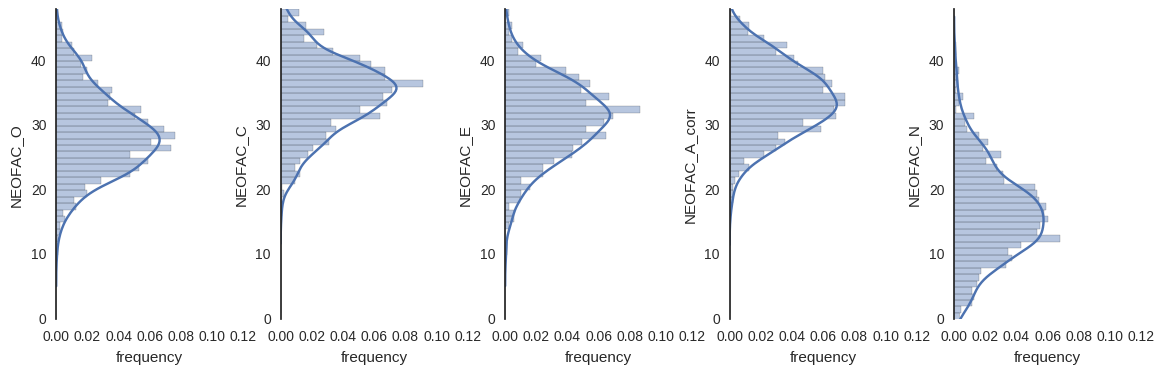

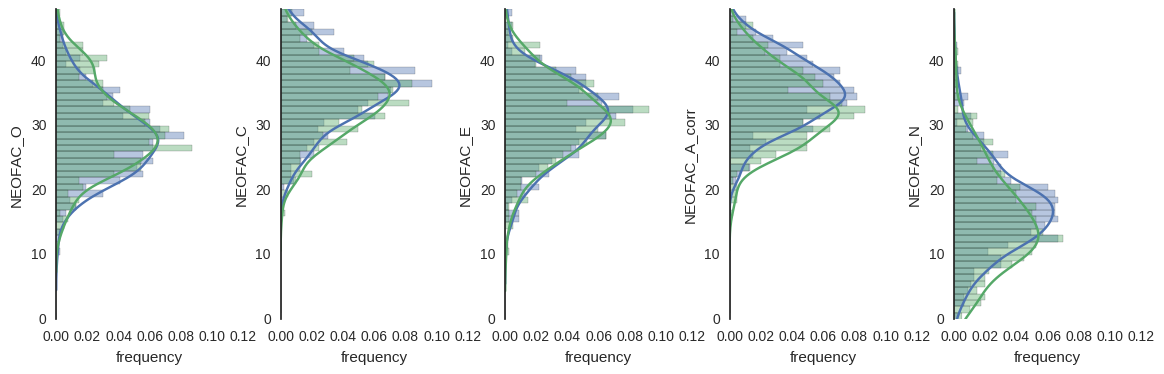

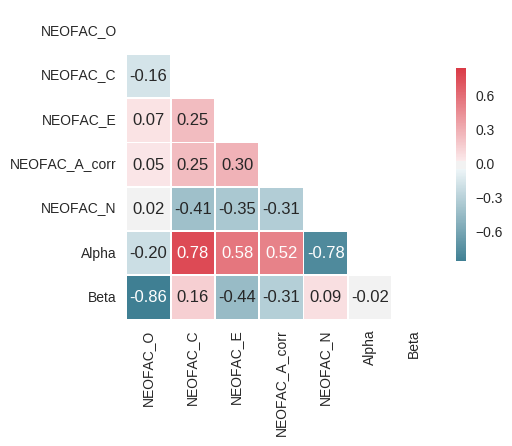

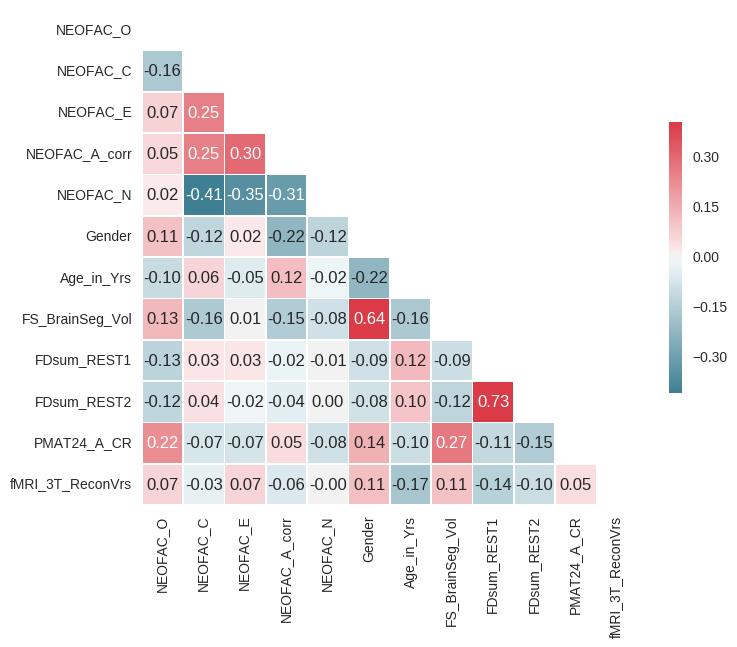

In [12]:
scoreMat = None
for score in scoreL:
    # add to conMat
    if scoreMat is None:
        scoreMat = np.ravel(df[score])
    else:
        scoreMat = np.vstack((scoreMat,np.ravel(df[score])))
df[scoreL].to_csv(op.join(outDir,'NEOFACscores.csv'))

itemL  = [
        'NEORAW_01','NEORAW_02','NEORAW_03','NEORAW_04','NEORAW_05','NEORAW_06','NEORAW_07','NEORAW_08','NEORAW_09','NEORAW_10',
        'NEORAW_11','NEORAW_12','NEORAW_13','NEORAW_14','NEORAW_15','NEORAW_16','NEORAW_17','NEORAW_18','NEORAW_19','NEORAW_20',
        'NEORAW_21','NEORAW_22','NEORAW_23','NEORAW_24','NEORAW_25','NEORAW_26','NEORAW_27','NEORAW_28','NEORAW_29','NEORAW_30',
        'NEORAW_31','NEORAW_32','NEORAW_33','NEORAW_34','NEORAW_35','NEORAW_36','NEORAW_37','NEORAW_38','NEORAW_39','NEORAW_40',
        'NEORAW_41','NEORAW_42','NEORAW_43','NEORAW_44','NEORAW_45','NEORAW_46','NEORAW_47','NEORAW_48','NEORAW_49','NEORAW_50',
        'NEORAW_51','NEORAW_52','NEORAW_53','NEORAW_54','NEORAW_55','NEORAW_56','NEORAW_57','NEORAW_58','NEORAW_59','NEORAW_60',
        ]        
# itemMat = None
# for item in itemL:
#     if itemMat is None:
#         itemMat  = np.ravel(df[item])
#     else:
#         itemMat = np.vstack((itemMat,np.ravel(df[item])))
df[itemL].to_csv(op.join(outDir,'itemScores.csv'))

# SHOW DISTRIBUTIONS
fig = plt.figure(figsize=(14,4))
for iScore,score in enumerate(scoreL):
    ax = fig.add_subplot(1,len(scoreL),iScore+1)
    sns.distplot(scoreMat[iScore,:],bins=range(49), vertical=True)
    ax.set(ylim=(0, 48), xlim=(0, .12), ylabel=score,xlabel="frequency")
    sns.despine(left=False, bottom=True)
    print stats.normaltest(scoreMat[iScore,:])
    
fig = plt.figure(figsize=(14,4))
for iScore,score in enumerate(scoreL):
    ax = fig.add_subplot(1,len(scoreL),iScore+1)
    sns.distplot(scoreMat[iScore,np.ravel(df['Gender'])==1], vertical=True, bins=range(49), ax=ax, kde=True)
    sns.distplot(scoreMat[iScore,np.ravel(df['Gender'])==2], vertical=True, bins=range(49), ax=ax, kde=True)
    ax.set(ylim=(0, 48), xlim=(0, .12), ylabel=score,xlabel="frequency")
    sns.despine(left=False, bottom=True)
    
thisdf = df[scoreL].copy()
thisdf['Alpha'] = df['Alpha']
thisdf['Beta']  = df['Beta']
corr   = thisdf.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(5,5));
sns.set(style="white")
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
for i1,score1 in enumerate(scoreL):
    for i2,score2 in enumerate(scoreL):
        if i2>i1:
            tmpCorr = stats.pearsonr(np.ravel(df[score1]),np.ravel(df[score2]))
            print '{} - {} : rho = {:.3f}, p = {:.2E}'.format(score1,score2,tmpCorr[0],tmpCorr[1])

SML    = ['NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A_corr', 'NEOFAC_N',
          'Gender','Age_in_Yrs','FS_BrainSeg_Vol','FDsum_REST1','FDsum_REST2','PMAT24_A_CR','fMRI_3T_ReconVrs']
thisdf = df[SML].copy()
corr = thisdf.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style="white")
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Confound removal assessment

NEOFAC_O
0.110773, -0.101788, -0.102071, 0.076259, 0.035805, 0.126976, -0.128089, 0.065090, 0.221253
-0.000000, 0.000000, -0.000016, 0.004929, 0.007260, -0.000000, 0.000000, -0.000000, -0.000000
NEOFAC_C
-0.117760, 0.063915, 0.062402, -0.096768, -0.066784, -0.159981, 0.028008, -0.032761, -0.067115
0.000000, -0.000000, -0.001828, -0.003041, -0.005522, 0.000000, -0.000000, 0.000000, 0.000000
NEOFAC_E
0.019481, -0.050824, -0.051088, -0.003363, -0.023153, 0.012988, 0.025882, 0.066094, -0.074897
-0.000000, 0.000000, -0.000533, -0.003630, -0.007276, -0.000000, 0.000000, -0.000000, -0.000000
NEOFAC_A_corr
-0.223815, 0.115816, 0.114901, -0.184792, -0.129169, -0.149601, -0.022807, -0.058472, 0.049389
0.000000, -0.000000, -0.000340, -0.004544, -0.008373, 0.000000, -0.000000, 0.000000, 0.000000
NEOFAC_N
-0.124441, -0.018397, -0.016233, -0.131039, -0.119209, -0.084493, -0.010331, -0.000656, -0.083101
-0.000000, 0.000000, 0.002284, 0.000803, 0.002186, -0.000000, 0.000000, -0.000000, -0.000000


,NEOFAC_O,NEOFAC_C,NEOFAC_E,NEOFAC_A_corr,NEOFAC_N
0,-7.767058,-6.827685,1.289948,-3.731858,5.489978
1,-4.150778,-0.126888,7.108390,1.763308,-2.350226
2,3.943151,-0.487083,1.991293,0.954125,-0.860408
3,2.690748,2.665011,-15.677134,-1.694104,-7.800247
4,-2.908554,3.053301,-1.954553,-4.994392,-4.208810
5,-6.942268,1.880514,-4.961085,3.371831,-13.736970
6,1.937833,9.742469,0.879281,-0.729839,-7.984707
7,10.192503,-2.991671,6.370586,6.190976,3.670653
8,4.945542,3.244688,-3.768163,-5.817109,0.906029
9,9.162586,-6.387632,-3.662954,-6.904979,-3.390350


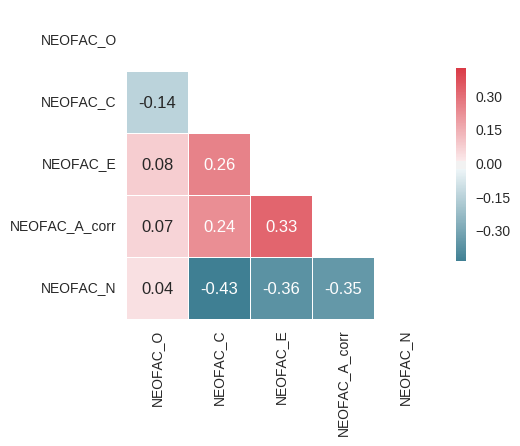

In [9]:
decon = 'decon+IQ'

if decon == 'megatrawlDecon':
    confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
elif decon == 'megatrawlDecon+IQ':
    confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
elif decon == 'decon':
    confounds=['gender','age','brainsize','motion','recon']
elif decon == 'decon+IQ':
    confounds=['gender','age','brainsize','motion','recon','PMAT24_A_CR']
elif decon == 'noDecon':
    confounds=[]

allConfounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']

# make a matrix with all confounds
conMatAll = None
for confound in allConfounds:
    if confound == 'gender':
        conVec = df['Gender']
    elif confound == 'age':
        conVec = df['Age_in_Yrs']
    elif confound == 'age^2':
        conVec = np.square(df['Age_in_Yrs'])
    elif confound == 'gender*age':
        conVec = np.multiply(df['Gender'],df['Age_in_Yrs'])
    elif confound == 'gender*age^2':
        conVec = np.multiply(df['Gender'],np.square(df['Age_in_Yrs']))
    elif confound == 'brainsize':
        conVec = df['FS_BrainSeg_Vol']
    elif confound == 'motion':
        conVec = df['FDsum_REST1']
    elif confound == 'recon':
        conVec = df['fMRI_3T_ReconVrs']
    elif confound == 'PMAT24_A_CR':
        conVec = df['PMAT24_A_CR']
    # add to conMat
    if conMatAll is None:
        conMatAll = np.array(np.ravel(conVec))
    else:
        conMatAll = np.vstack((conMatAll,conVec))
conMatAll = conMatAll.T

# make a matrix with just the confounds used
conMat = None
for confound in confounds:
    if confound == 'gender':
        conVec = df['Gender']
    elif confound == 'age':
        conVec = df['Age_in_Yrs']
    elif confound == 'age^2':
        conVec = np.square(df['Age_in_Yrs'])
    elif confound == 'gender*age':
        conVec = np.multiply(df['Gender'],df['Age_in_Yrs'])
    elif confound == 'gender*age^2':
        conVec = np.multiply(df['Gender'],np.square(df['Age_in_Yrs']))
    elif confound == 'brainsize':
        conVec = df['FS_BrainSeg_Vol']
    elif confound == 'motion':
        conVec = df['FDsum_REST1']
    elif confound == 'recon':
        conVec = df['fMRI_3T_ReconVrs']
    elif confound == 'PMAT24_A_CR':
        conVec = df['PMAT24_A_CR']
    # add to conMat
    if conMat is None:
        conMat = np.array(np.ravel(conVec))
    else:
        conMat = np.vstack((conMat,conVec))
conMat = conMat.T


# deconfound scores
tmpdf = df[scoreL].copy()

# check correlations with all confounds
for score in scoreL:
    print score
    # correlations before
    corrBef = []
    for i in range(len(allConfounds)):
        corrBef.append(stats.pearsonr(conMatAll[:,i].T,np.ravel(df[score]))[0])
    print(', '.join('{:03f}'.format(k) for k in corrBef))
    # regress out confounds
    regr        = linear_model.LinearRegression()
    regr.fit(conMat, np.ravel(df[score]))
    fittedvalues = regr.predict(conMat)
    deconScore   = np.ravel(df[score]) - np.ravel(fittedvalues)
    # correlations after
    corrAft = []
    for i in range(len(allConfounds)):
        corrAft.append(stats.pearsonr(conMatAll[:,i].T,deconScore)[0])
    print(', '.join('{:03f}'.format(k) for k in corrAft))
    # aggregate deconfounded scores
    tmpdf[score] = deconScore

corr   = tmpdf.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(5,5));
sns.set(style="white")
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Superordinate factors

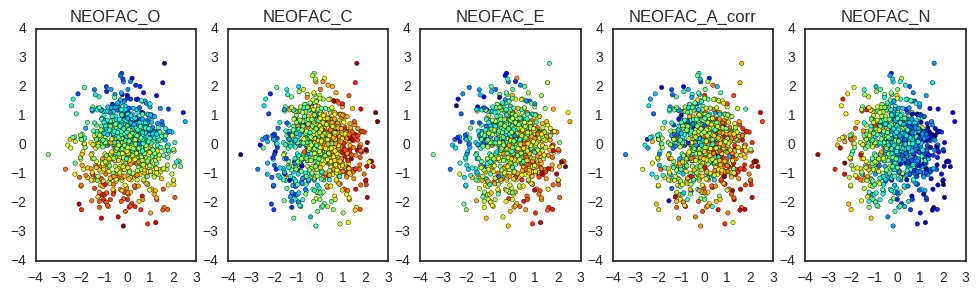

In [11]:
# load factor loadings from matlab!
# in Matlab, run function factoranalysis.m after copying NEOFACscores.csv and itemScores.csv to the Dropbox folder
projections = np.loadtxt(open(op.join(outDir,'higherOrder.csv'), "rb"), delimiter=",",dtype=np.float32)

sizes = 10*np.ones(projections.shape[0])
# sizes[isOut] = 100
fig = plt.figure(figsize=(12,3));
reorder = np.argsort(sizes)
for iScore,score in enumerate(scoreL):
    ax = fig.add_subplot(1,len(scoreL),iScore+1)
    plt.scatter(projections[reorder,0],projections[reorder,1],s=sizes[reorder],c=np.ravel(df[score][reorder]),cmap=plt.cm.jet)
    plt.title(score)
    
# add to df
df['Alpha'] = projections[:,0]
df['Beta']  = projections[:,1]

# Do work

### preprocess everybody

In [8]:
config.overwrite               = False
config.sgeopts                 = '-l mem_free=25G -pe smp 6' 
overwriteFC                    = False
# config.sgeopts                 = '-l mem_free=1G' 
# overwriteFC                    = True

config.Operations              = config.operationDict[config.pipelineName]
if config.pipelineName in ['SiegelA','SiegelB']:
    config.useFIX              = True
else:
    config.useFIX              = False
    
config.scriptlist = list()
keepSub = np.zeros((len(df['Subject'])),dtype=np.bool_)
iSub    = 0
for subject in df['Subject']:
    config.subject = str(subject)
    iRun = 0
    for config.fmriRun in fmriRuns:
        keepSub[iSub] = runPipelinePar(launchSubproc=False,overwriteFC=overwriteFC)
        if not keepSub[iSub]:
            break
        iRun=iRun+1
    iSub = iSub + 1
print 'Keeping {}/{} subjects'.format(np.sum(keepSub),len(df['Subject']))

# prune and reindex
df        = df[keepSub]
df.index  = range(df.shape[0])

# launch array job (if there is something to do)
if len(config.scriptlist)>0:
    if len(config.scriptlist)<10:
        print config.scriptlist
    JobID = fnSubmitJobArrayFromJobList()
    print 'Running array job {} ({} sub jobs)'.format(JobID.split('.')[0],JobID.split('.')[1].split('-')[1].split(':')[0])
    config.joblist.append(JobID.split('.')[0])
    checkProgress(pause=60,verbose=False)

Keeping 867/867 subjects


### run prediction in entire subject pool

In [11]:
# make new dataframe
newdf       = df.copy()

# print the list of subjects to a txt file for reference
outFile = op.join(outDir,'subjectList.txt');
np.savetxt(outFile, newdf['Subject'])

# dump dataframe to file
dataFile = op.join(outDir,'df.csv')
newdf.to_csv(dataFile, sep=',', encoding='utf-8')    

#----------------------
# save fcMats    
#----------------------
# if any preprocessing still needs to be run, run it
config.queue        = True
config.sgeopts      = '-l mem_free=25G -pe smp 6' 
config.overwrite    = False
config.fmriFile_dn  = ''

fcMatFile =  op.join(outDir,'fcMats.mat')
overwrite  = False
if (not op.isfile(fcMatFile)) or overwrite:
    fcMats_dn = np.zeros((config.nParcels,config.nParcels,newdf.shape[0],len(fmriRuns)),dtype=np.float32)
    iSub= 0
    for subject in newdf['Subject']:
        config.subject = str(subject)
        iRun = 0
        for config.fmriRun in fmriRuns:
            # set the global variable config
            runPipelinePar(launchSubproc=False)
            tsDir = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
            rstring = get_rcode(config.fmriFile_dn)
            fcFile_dn = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
            thisTime  = ctime(op.getmtime(fcFile_dn))
            if "Oct 25" not in thisTime:
                print "{}-{} last modified: {}".format(subject,config.fmriRun,thisTime)
            fcMats_dn[:,:,iSub,iRun] = np.genfromtxt(fcFile_dn,delimiter=",")
            iRun = iRun+1
        iSub = iSub + 1
    # SAVE REST1 fcMats
    fcMats_REST1 = np.squeeze(np.mean(np.arctanh(fcMats_dn[:,:,:,0:2]),3))
    fcMats_REST2 = np.squeeze(np.mean(np.arctanh(fcMats_dn[:,:,:,2:4]),3))
    results      = {}
    results['fcMats_REST1']  = fcMats_REST1
    results['fcMats_REST2']  = fcMats_REST2
    results['subjects']      = np.str(np.asarray(newdf['Subject']))
    sio.savemat(fcMatFile, results)

    
# make a random subject order -- for permutation testing
if not op.isfile(op.join(outDir,'permInds.txt')):
    permInds = np.vstack([np.random.permutation(range(newdf.shape[0])) for i in range(1000)])
    np.savetxt(op.join(outDir,'permInds.txt'), permInds)

nPerm = 0
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False
for session in ['REST1','REST2']:
    print ('{}, nsub{}, {}, {}, {}'.format(
        config.release,newdf.shape[0],config.pipelineName,config.parcellationName,session))
    for model in ['Finn','elnet']:#, 'mlr','lasso', 'elnet']:,'Finn-stable','elnet-stable'
        if (model=='Finn'):
            filterThr = .01
        else:
            filterThr = .01
        print '> {} thr{:.2f}'.format(model,filterThr)
        for SM in ['PMAT24_A_CR','NEOFAC_A_corr','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E','Alpha','Beta']: #
            print '--------> '+ SM
            if (SM=='PMAT24_A_CR') :
                decon = 'decon'
            else:
                decon = 'decon+IQ'
            thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                SM,config.pipelineName,config.parcellationName, session, decon, model, config.release,filterThr)) 
            if not op.isdir(thisOutDir):
                mkdir(thisOutDir)
                
            # REAL & PERMUTED PREDICTIONS
            for iPerm in range(nPerm+1): 
                thisOutDir_ = op.join(thisOutDir,'{0:04d}'.format(iPerm))
                if not op.isdir(thisOutDir_):
                    mkdir(thisOutDir_)

                resFile    = op.join(thisOutDir_,'result.mat') 
                    
                if not op.isfile(resFile) or config.overwrite:
                    if decon == 'megatrawlDecon':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
                    elif decon == 'megatrawlDecon+IQ':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'decon':
                        confounds=['gender','age','brainsize','motion','recon']
                    elif decon == 'decon+IQ':
                        confounds=['gender','age','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'noDecon':
                        confounds=[]
                    # run this thrice, just in case some jobs fail -- it happens
                    for rep in range(3):
                        runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,idcode=session+'_'+decon,outDir=thisOutDir_,
                                        confounds=confounds,filterThr=.01,iPerm=iPerm)
                        checkProgress(pause=10,verbose=False)
                        sleep(10)
                    # merge cross-validation folds, save results
                    predictions_posneg = np.zeros([newdf.shape[0],1])
                    predictions_pos    = np.zeros([newdf.shape[0],1])
                    predictions_neg    = np.zeros([newdf.shape[0],1])
                    for el in np.unique(newdf['Family_ID']):
                        test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                        test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                        cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                            '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                        results = sio.loadmat(cvResFile) 
                        if model=='Finn':
                            predictions_posneg[test_index] = results['pred_posneg'].T
                            predictions_pos[test_index]    = results['pred_pos'].T
                            predictions_neg[test_index]    = results['pred_neg'].T
                        else:
                            predictions_pos[test_index] = results['pred'].T

                    if model=='Finn':
                        rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.squeeze(np.ravel(newdf[SM])))
                        rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[SM])))
                        rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(newdf[SM])))
                        results = {'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                    else:
                        rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[SM])))
                        results = {'pred':predictions_pos, 'rho':rho, 'p': p}

                    # save result
                    sio.savemat(resFile,results)

                while not op.isfile(resFile):
                    sleep(.1)

                if iPerm==0:
                    results = sio.loadmat(resFile)
                    if model=='Finn':
                        print ('posneg,rho={0:.3f},p={1:.5f},[pos,rho={2:.3f},p={3:.5f};neg,rho={4:.3f},p={5:.5f}]'.format(
                            results['rho_posneg'][0][0],results['p_posneg'][0][0],
                            results['rho_pos'][0][0],results['p_pos'][0][0],
                            results['rho_neg'][0][0],results['p_neg'][0][0])
                              )
                    else:
                        print ('rho={0:.3f},p={1:.5f}'.format(
                            results['rho'][0][0],results['p'][0][0])
                              )

all+MEG2, nsub867, Ciric6, Glasser, REST1
> Finn thr0.01
--------> PMAT24_A_CR
posneg,rho=0.223,p=0.00000,[pos,rho=0.213,p=0.00000;neg,rho=0.175,p=0.00000]
--------> NEOFAC_A_corr
posneg,rho=0.117,p=0.00056,[pos,rho=0.111,p=0.00106;neg,rho=0.098,p=0.00393]
--------> NEOFAC_O
posneg,rho=0.155,p=0.00000,[pos,rho=0.136,p=0.00006;neg,rho=0.140,p=0.00003]
--------> NEOFAC_C
posneg,rho=0.097,p=0.00420,[pos,rho=0.076,p=0.02469;neg,rho=0.087,p=0.01015]
--------> NEOFAC_N
posneg,rho=-0.069,p=0.04341,[pos,rho=0.012,p=0.72881;neg,rho=-0.112,p=0.00093]
--------> NEOFAC_E
posneg,rho=0.060,p=0.07713,[pos,rho=0.072,p=0.03485;neg,rho=0.050,p=0.13794]
--------> Alpha
posneg,rho=0.038,p=0.25852,[pos,rho=-0.044,p=0.19277;neg,rho=0.071,p=0.03788]
--------> Beta
posneg,rho=0.149,p=0.00001,[pos,rho=0.120,p=0.00041;neg,rho=0.146,p=0.00002]
> elnet thr0.01
--------> PMAT24_A_CR
rho=0.218,p=0.00000
--------> NEOFAC_A_corr
rho=0.040,p=0.23958
--------> NEOFAC_O
rho=0.236,p=0.00000
--------> NEOFAC_C
rho=0.023,p